
=== Original x0: A vs B ===
mean: -0.017 vs 4.988
std : 0.992 vs 1.394
KS   : stat=0.9688, p=0.0000
t-test(means): stat=-206.9262, p=0.0000
Levene(vars) : stat=507.0810, p=0.0000


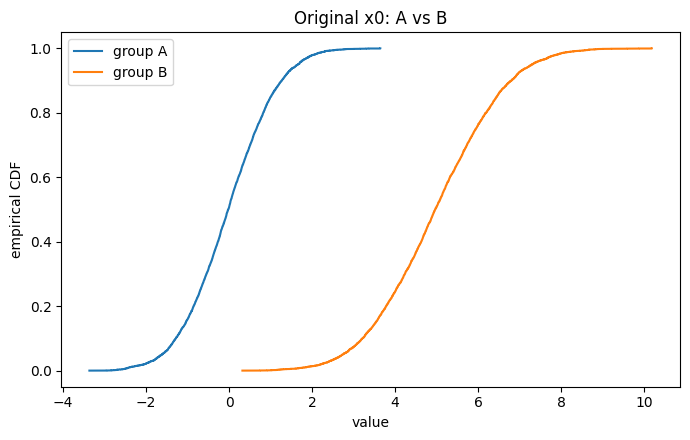

NameError: name 'model' is not defined

In [3]:
import torch, numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats

DEVICE        = 'cpu' 
T             = 500        # diffusion steps
BATCH_SIZE    = 512
TRAIN_ITERS   = 2000       # 訓練步數
LR            = 5e-4
HIDDEN        = 512
TIME_DIM      = 64
N_TRAIN_SAMP  = 10000       # 訓練資料量）
### Constants setting
betas = torch.linspace(1e-4, 0.02, T+1, device=DEVICE)
alphas = 1.0-betas
abar = torch.cumprod(alphas, dim=0)
sqrt_abar = torch.sqrt(abar)
sqrt_lmabar = torch.sqrt(1.0-abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)


# ========= 1) 生成兩群常態資料 =========
def make_two_normals(n_each=5000, mu1=0.0, var1=1.0, mu2=5.0, var2=2.0, device='cpu'):
    x1 = torch.randn(n_each, 1, device=device) * (var1**0.5) + mu1
    x2 = torch.randn(n_each, 1, device=device) * (var2**0.5) + mu2
    return x1, x2

# ========= 2) 前向擴散（加噪） =========
@torch.no_grad()
def forward_diffuse(x0, t):
    """
    x0: (N,1), t: int 或 長度為 N 的 LongTensor (1..T)
    回傳 x_t 與當次用到的 eps
    """
    if not torch.is_tensor(t):
        t = torch.full((x0.shape[0],), int(t), device=x0.device, dtype=torch.long)
    eps = torch.randn_like(x0)
    x_t = sqrt_abar[t].unsqueeze(1) * x0 + sqrt_lmabar[t].unsqueeze(1) * eps
    return x_t, eps

# ========= 3) 反向擴散（去噪）從 t_start -> 0 =========
@torch.no_grad()
def denoise_from_t(model, x_t, t_start):
    """
    用訓練好的 model，從 t_start 一路 denoise 到 0
    """
    model.eval()
    n = x_t.shape[0]
    for t in range(int(t_start), 0, -1):
        tt = torch.full((n,), t, device=x_t.device, dtype=torch.long)
        eps_hat = model(x_t, tt)

        a_t   = alphas[t]
        abar_t = abar[t]
        beta_t = betas[t]
        abar_tm1 = abar[t-1] if t > 1 else torch.tensor(1.0, device=x_t.device)

        beta_tilde = (1 - abar_tm1) / (1 - abar_t) * beta_t
        mean = (1.0/torch.sqrt(a_t)) * (x_t - (beta_t/torch.sqrt(1-abar_t)) * eps_hat)

        if t > 1:
            x_t = mean + torch.sqrt(beta_tilde) * torch.randn_like(x_t)
        else:
            x_t = mean
    return x_t  # 近似 x_0

# ========= 4) 視覺化 & 檢定工具 =========
def ecdf(a: np.ndarray):
    s = np.sort(a)
    n = s.size
    y = np.arange(1, n+1)/n
    return s, y

def compare_two_groups(title, a, b):
    a_np = a.detach().flatten().cpu().numpy()
    b_np = b.detach().flatten().cpu().numpy()

    # KS / t-test / Levene
    ks_stat, ks_p = stats.ks_2samp(a_np, b_np)
    tt_stat, tt_p = stats.ttest_ind(a_np, b_np, equal_var=False)
    lv_stat, lv_p = stats.levene(a_np, b_np)

    print(f"\n=== {title} ===")
    print(f"mean: {a_np.mean():.3f} vs {b_np.mean():.3f}")
    print(f"std : {a_np.std(ddof=1):.3f} vs {b_np.std(ddof=1):.3f}")
    print(f"KS   : stat={ks_stat:.4f}, p={ks_p:.4f}")
    print(f"t-test(means): stat={tt_stat:.4f}, p={tt_p:.4f}")
    print(f"Levene(vars) : stat={lv_stat:.4f}, p={lv_p:.4f}")

    xs, Fx = ecdf(a_np); ys, Fy = ecdf(b_np)
    plt.figure(figsize=(7,4.5))
    plt.step(xs, Fx, where="post", label="group A")
    plt.step(ys, Fy, where="post", label="group B")
    plt.xlabel("value"); plt.ylabel("empirical CDF")
    plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

# ========= 5) 實驗：完整去噪 vs 局部去噪 =========
# 兩群分佈（你說的 N(5,2) 我這裡解讀為 mean=5, variance=2；另一群自選）
xA0, xB0 = make_two_normals(n_each=5000, mu1=0.0, var1=1.0, mu2=5.0, var2=2.0, device=DEVICE)

# (a) 原始分佈比較（應該顯著不同）
compare_two_groups("Original x0: A vs B", xA0, xB0)

# (b) 完整擴散到 T 再去噪回 0（情報遺失 → 會變成混合分佈）
xAT, _ = forward_diffuse(xA0, T)     # 先 forward 到 T
xBT, _ = forward_diffuse(xB0, T)
xA_recon_full = denoise_from_t(model, xAT, T)
xB_recon_full = denoise_from_t(model, xBT, T)
compare_two_groups("Denoise from T: A vs B (expect ~indistinguishable)", xA_recon_full, xB_recon_full)

# (c) 只擴散到小 t 再去噪（保留部分訊息 → 仍可分）
t_small = max(1, T//10)               # 例如 10% 的噪聲深度
xAt, _ = forward_diffuse(xA0, t_small)
xBt, _ = forward_diffuse(xB0, t_small)
xA_recon_partial = denoise_from_t(model, xAt, t_small)
xB_recon_partial = denoise_from_t(model, xBt, t_small)
compare_two_groups(f"Denoise from t={t_small}: A vs B (should remain different)", xA_recon_partial, xB_recon_partial)
